# Data Labeling Lab

## Goal
본 실습의 목표는 Amazon Mechanical Turk와 같은 플랫폼을 통해 사용자들로부터 데이터에 정답을 부착했을 때, 이를 머신러닝 학습에 사용할 수 있도록 후처리하는 방법을 배우는 것입니다.

## Dataset

In [0]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict

학습 데이터를 다운로드하고 압축을 풉니다.

데이터 출처: http://www.cs.cornell.edu/~cristian/Politeness.html

In [2]:
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

--2019-08-01 04:50:20--  http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34676352 (33M) [application/zip]
Saving to: ‘Stanford_politeness_corpus.zip’

Stanford_politeness 100%[===================>]  33.07M  14.0MB/s    in 2.4s    

2019-08-01 04:50:23 (14.0 MB/s) - ‘Stanford_politeness_corpus.zip’ saved [34676352/34676352]

Archive:  Stanford_politeness_corpus.zip
   creating: Stanford_politeness_corpus/
  inflating: Stanford_politeness_corpus/Readme.txt  
  inflating: Stanford_politeness_corpus/stack-exchange.annotated.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.requests.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.roles.csv  
  inflating: Stanford_politeness_corpus/wikipedia.admins.csv  
  inflating: Stanford_

requests 정답 부착되지않은 원시데이터 크롤링한거 양 존나많음
annotated 아마존 메카니컬파크를 통해 사람들에게 공손함 측정한 결과7

다운로드된 데이터셋은 CSV 파일 형태로 되어 있습니다.

pandas 패키지의 read_csv 함수를 이용하면 이를 편리하게 읽어올 수 있습니다.

In [3]:
data = pd.read_csv("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)  ## 축약되는거없이 다 봄

print(data.head()) ## 데이터의 첫 5번쨰 

## 위키피디아

## 같은문장에 대해서 여러사람한테 물어봐서 의견을 종합 같은 문장에대해 5명에게 점수매김
# 필터링 방식
## 이사람이 영어를 잘하는 사람인지에 대해 테스트하는거 +함  (영어를 잘하는지 테스트)
## (귀찮아서 대충할경우) 한사람이 너무 균일하게 하면 삭제 
## Turkid1 A2UFD1I8ZO1V4G 각각의 점수를 누가 부여했는지 알수있게
## Normalized Score 기계학습에서 쓸수있는 정답만드는? 점수

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  
0   AYG3MF094634

각 칼럼에 대한 자세한 정보 등은 Readme.txt 파일에 있습니다.

Community - always "Wikipedia" in this file

Id - Unique ID of the request (can be used to match the requests with the metadata in  wikipedia.requests.csv)

Request - text of the request

Score[1-5] - politeness scores assigned by each of the 5 annotators, between 1 (very impolite) and 25 (very polite)

TurkId[1-5]	- the Amazon Mechanical Turk ids of each of the 5 annotators

Normalized Score - the normalized politeness score of the requests (after normalizing each annotator's score; details in Section 2 of the paper)


가장 단순하게는 5개 Score의 평균을 내서 각 문장에 대한 정답을 부여할 수 있을 것입니다.

이런 방법으로 각 문장마다 점수를 내고 이를 시각화해볼까요?

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  avg_score  
0   A

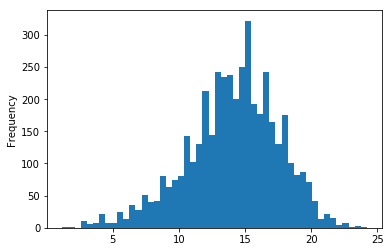

In [4]:
def calc_avg(row):  ## 하나의 데이터 행이 있을때 포문 돌면서 스코어 다 더해서 평균냄
  sum = 0
  for i in range(1, 6, 1):
    sum += row["Score%d" %i] ## 점수 의 평균괌
  
  return sum / 5.0
  
data["avg_score"] = data.apply(lambda row: calc_avg(row), axis=1) ## 각각 로우함수에다가 에버러지 컬럼 스코어 칼럼 추가해라 ## apply가 돌면서 자동으로 닿줌

print(data.head())
data["avg_score"].plot.hist(bins=50)## bins 막대기 몇개그릴지 세밀하게, 큰그림 등등  # 공손함은 모호한게 많아서 중간이 많음
#
## ex 정치뉴스, 스포츠 뉴스 이러면 양쪽 끝과끝으로 나뉨

위 방법에는 몇 가지 문제가 있습니다.


1.   사람마다 느끼는 공손함의 정도는 주관적입니다.
2.   각 문장마다 서로 다른 사람이 점수를 부여했기 때문에 같은 점수를 같은 정도의 공손함이라고 해석할 수 없습니다.

이를 해결하기 위해, 각 사람마다의 점수 분포를 정규화해줄 수 있습니다.

TurkId 항목을 이용해 각각의 사람이 부여한 점수를 모으고, 이로부터 각 사람이 부여한 점수의 평균과 표준편차를 계산해봅시다.



정규분포를 통해 사람의 성향에 따라 점수를 
사람 id가지고 각각 개인이 판단을 하는 중심기준이 어느정도인지 찾는게 목표
어떤사람은 10을 중심으로 어떤사람은 20을중심으로 등등
이런것들을 통일해주기위해
각사람이 점수준거에 대해 평균과 표준편차 => 모든 평균 0 표준분포 1인 정규분포 만듬
정규화(z노말라이제이션)

In [0]:

for idx, row in data.iterrows(): 
  print(idx)
  print("================")
  print(row["TurkId2"])

In [23]:
worker_scores = defaultdict(list)  ## 내가 원하는 키 없으면 에러 내는 대신에 빈 리스트 반환 원래는 에러 # 키는 터크아이디, 벨류는 그사람이 매긴 점수 리스트

# Your code here
for idx, row in data.iterrows(): ## iterrows() 몇번쨰행인지, 그행데이터 이터레이터 반환
  for i in range(1, 6, 1):
    worker_scores[row["Turkld%d" %i]].append(row["Score%d" %i])
    
# for worker_id in worker_scores:
#   worker_mean[worker_id] = np.mean(worker_scores[workers_id])
#   worker_std[worker_id] = np.std(worker_scores[worker_id])

# print(worker_mean)
# print(worker_std)


print(worker_scores)



#      
#     worker_scores[row["Turkld"+i]]= row["Score"+i] 


# worker_mean = {}
# worker_std = {}

# # Your code here
# np.mean([....])  
# np.std([...]) ## 표준편차
# print(worker_mean)
# print(worker_std)
                  

KeyError: ignored

그 다음으로, 각 사람이 부여한 점수에서 그 사람의 점수들의 평균을 빼고, 표준편차로 나누어줍니다. 

이를 z-normalization이라고 합니다.

이렇게 하면 모든 사람의 점수가 평균 0, 표준편차 1의 분포를 가지게 됩니다. 따라서 점수를 부여한 사람을 신경쓰지 않고 점수들을 비교할 수 있습니다.

In [0]:
# 스코어 별로   Score1  Score2  Score3  Score4  Score5 제트노말라이제이션한 컬럼들 추가

# Your code here
def z_norm(row,i):
  worker_id = row["Turkld%d" %]
  
  
  
print(data.head())

이제 사람들 간의 점수 편차를 최소화했으니, 정규화된 점수들의 평균을 내봅시다.

평균 점수를 계산하고, 이를 "Normalized Score" 칼럼의 값과 비교해보세요.

이전과 같이 히스토그램을 통해 시각화도 해보시기 바랍니다.

가운데 중립적인문장 분포가 많으면 공손하지도않도 불손하지도 않다. 
결국 최종적으로 공손불손 측정도 이그래프 따르게 됨 
이런 데이터 모델 학습시키면 학습잘안되고 방해만됨
중립적인 문장은 제외하고 극단적인경우만 라벨 붙이고 학습시킨다.


In [0]:
# Your code here

print(data.head())
data["avg_zn_score"].plot.hist(bins=50)

이제 각 문장마다 공손함 점수는 부여했지만, 아직 하나의 문제가 더 남았습니다.

공손함은 모호한 개념이기 때문에, 그리고 공손함을 따지기 어려운 중립적인 문장들이 많기 때문에 지금의 데이터에는 공손함을 따지기 어려운 중립적인 문장들이 많습니다.

이러한 경우는 점수가 중간에 분포하는 문장들을 학습 데이터에서 제거하는 것이 일반적입니다.

이 데이터에서는 가장 공손한 문장 25%와 가장 불손한 문장 25%만을 사용하고, 나머지는 폐기하겠습니다.

In [0]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75]) # z노말라이제이션된 스코어랑 값을 이용해서  하위 25퍼 상위 75% 이런거 계산해주는거 quantile 함수
                                                                  # 상위, 하위 25%만 쓴다. 상위 25% 공손 , 하위 25% 불손
  print(quantiles)

  # Your code here

  return data

data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
print(data.head())
print("데이터 수: %d" %len(data))